In [1]:
import os
import cv2
import numpy as np

In [2]:
INPUT_DIR = '/home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit'
OUTPUT_DIR = '/home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit_processed'

# this notebook merge the blender freestyle lines with the mesh

libpng warning: eXIf: duplicate
libpng warning: eXIf: duplicate


Freestyle image shape: (2048, 2048, 4)
Freestyle image type: uint8
Mesh image shape: (2048, 2048, 4)
Mesh image type: uint8


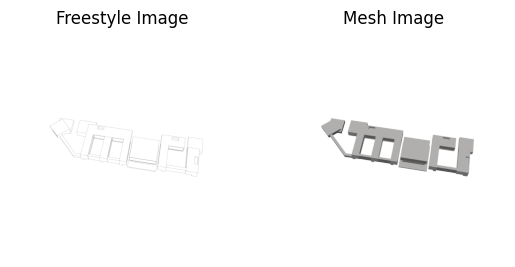

In [3]:
#first lets see what is the type and format of the files in the input directory
example_scene_freestyle = "/home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit/0/lod2/lod2_freestyle_az010_el60.png"
example_scene_mesh = "/home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit/0/lod2/lod2_mesh_az010_el60.png"

# load the freestyle image and the mesh image
freestyle_image = cv2.imread(example_scene_freestyle, cv2.IMREAD_UNCHANGED)
mesh_image = cv2.imread(example_scene_mesh, cv2.IMREAD_UNCHANGED)   

# check the shape and type of the images
print("Freestyle image shape:", freestyle_image.shape)
print("Freestyle image type:", freestyle_image.dtype)
print("Mesh image shape:", mesh_image.shape)
print("Mesh image type:", mesh_image.dtype) 

#show the freestyle image and the mesh image
import matplotlib.pyplot as plt
plt.subplot(1, 2, 1)
plt.imshow(freestyle_image)
plt.title('Freestyle Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(mesh_image)
plt.title('Mesh Image')
plt.axis('off')
plt.show()


Merged image shape: (2048, 2048, 4)


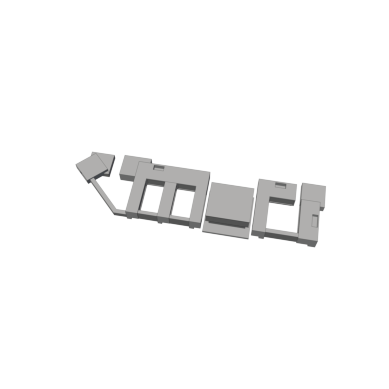

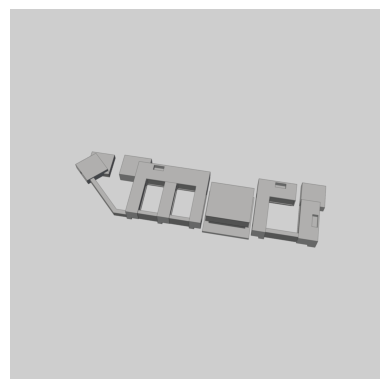

In [4]:
# Split channels
fs_rgb = freestyle_image[..., :3]
fs_alpha = freestyle_image[..., 3:] / 255.0  # normalize alpha to [0, 1]

mesh_rgb = mesh_image[..., :3]
mesh_alpha = mesh_image[..., 3:] / 255.0

# Composite RGB using alpha blending: fs over mesh
out_rgb = fs_rgb * fs_alpha + mesh_rgb * (1 - fs_alpha)

# Optional: Compose new alpha channel (keep mesh alpha if freestyle is transparent)
out_alpha = fs_alpha + mesh_alpha * (1 - fs_alpha)

# Merge RGB + alpha back
merged = np.dstack((out_rgb, out_alpha * 255)).astype(np.uint8)

# show the merged image with matplotlib
import matplotlib.pyplot as plt
print("Merged image shape:", merged.shape)
plt.imshow(merged)
plt.axis('off')
plt.show()

plt.imshow(cv2.cvtColor(merged, cv2.COLOR_RGBA2RGB))
plt.axis('off')
plt.show()



KeyboardInterrupt: 

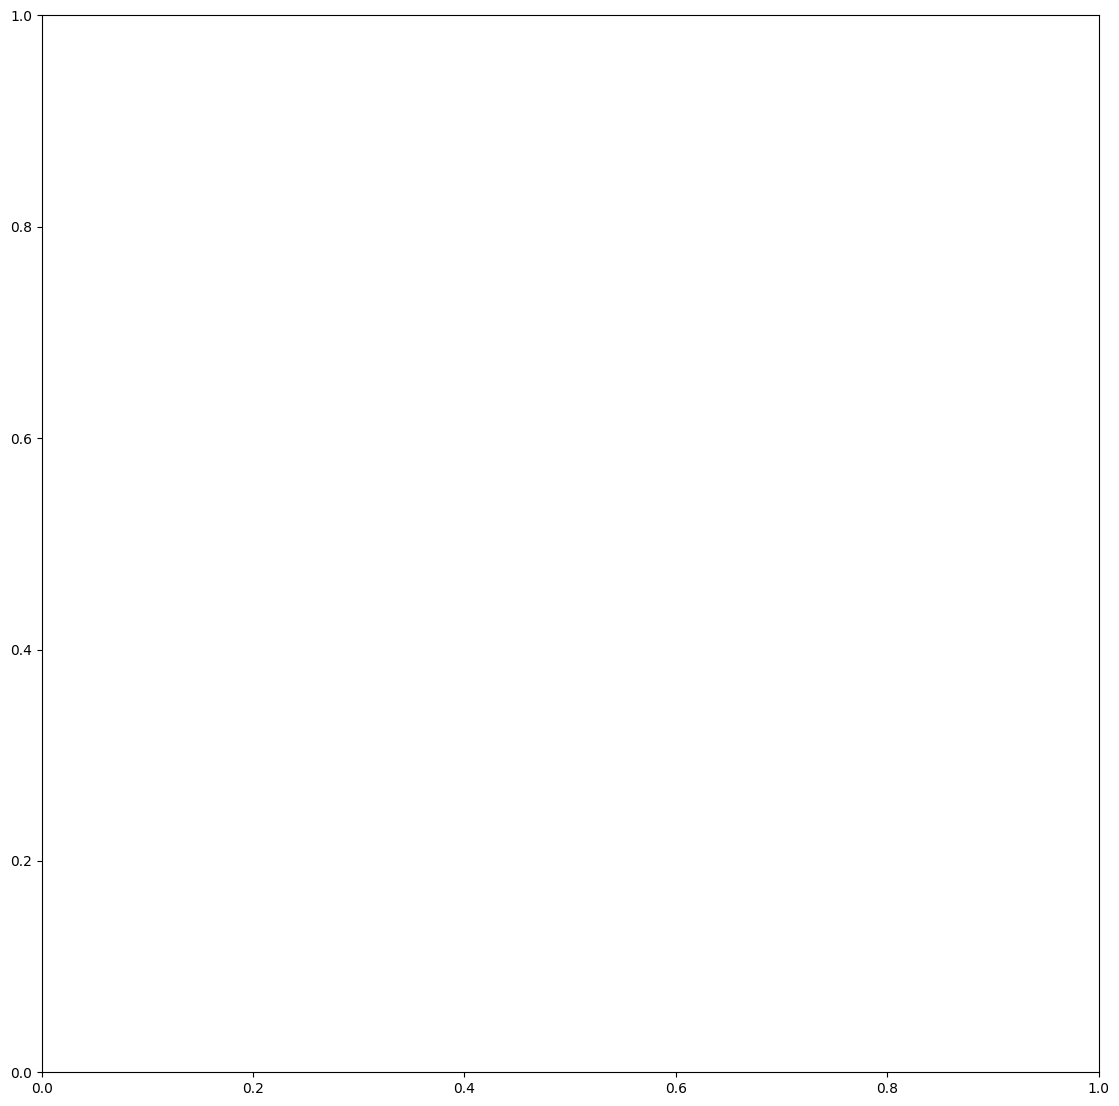

In [5]:
#apply canny edge detection to the merged image
low_threshold = 5
high_threshold = 10

image = cv2.Canny(merged, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)

# show the canny edge detected image
# versus the original mesh only image with canny edge detection
image_mesh = cv2.Canny(mesh_image, low_threshold, high_threshold)
image_mesh = image_mesh[:, :, None]
image_mesh = np.concatenate([image_mesh, image_mesh, image_mesh], axis=2)
plt.figure(figsize=(30, 15))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Merged Freestyle over Mesh')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(image_mesh)
plt.title('Mesh Only with Canny')
plt.axis('off')
plt.show()



In [ ]:
#we can see that the merged clearly have better edges than the mesh only image

# TODO: write a os walk loop to process all the images in the input directory with the same structure 
# aka /home/athiwat/progressive_img2sketch/resources/LOD50_Finer_orbit/{scene number (0-50)}/lod{1 or 2}/lod{1 or 2}_az010_el60.png"
merged_images_output_dir = os.path.join(OUTPUT_DIR, 'merged_images')
canny_images_output_dir = os.path.join(OUTPUT_DIR, 'canny_images')

os.makedirs(merged_images_output_dir, exist_ok=True)
os.makedirs(canny_images_output_dir, exist_ok=True)

for root, dirs, files in os.walk(INPUT_DIR):
    for file in files:
        if file.endswith('.png') and 'freestyle' in file:
            freestyle_path = os.path.join(root, file)
            mesh_path = freestyle_path.replace('freestyle', 'mesh')

            # Load images
            freestyle_image = cv2.imread(freestyle_path, cv2.IMREAD_UNCHANGED)
            mesh_image = cv2.imread(mesh_path, cv2.IMREAD_UNCHANGED)

            # Process as before
            fs_rgb = freestyle_image[..., :3]
            fs_alpha = freestyle_image[..., 3:] / 255.0

            mesh_rgb = mesh_image[..., :3]
            mesh_alpha = mesh_image[..., 3:] / 255.0

            out_rgb = fs_rgb * fs_alpha + mesh_rgb * (1 - fs_alpha)
            out_alpha = fs_alpha + mesh_alpha * (1 - fs_alpha)

            merged = np.dstack((out_rgb, out_alpha * 255)).astype(np.uint8)
            merged = cv2.cvtColor(merged, cv2.COLOR_RGBA2RGB)
            
            # Save merged image
            merged_output_path = os.path.join(merged_images_output_dir, file)
            cv2.imwrite(merged_output_path, merged)

            # Canny edge detection
            canny_image = cv2.Canny(merged, low_threshold, high_threshold)
            canny_image_colored = np.stack([canny_image] * 3, axis=-1)  # Convert to 3-channel

            # Save Canny image
            canny_output_path = os.path.join(canny_images_output_dir, file)
            cv2.imwrite(canny_output_path, canny_image_colored)
            print(f"Processed {file}: saved merged to {merged_output_path} and Canny to {canny_output_path}")